### Load data

In [1]:
import pandas as pd
predictions = pd.read_csv("./data/predictions_up.csv")
predictions.head()

,label,predReg,predGbt,predReg_up
0,0,3.482221e-12,0.004599,0.019115
1,0,5.931836e-05,0.005975,0.013693
2,0,2.187130e-02,0.027379,0.379243
3,0,5.470528e-05,0.005071,0.017319
4,0,1.706345e-06,0.005838,0.018895


### Calibration error

In [2]:
import math
def calibrationError(predictions, modelName, bucketSize = 100):
    count, sumPrediction, sumLabel = 0, 0, 0
    bucketReturnRate = []
    bucketPrediction = []
    bucketErrors = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        sumPrediction = sumPrediction + row[modelName]
        count = count + 1
        if(count == bucketSize):
            predMean = sumPrediction / float(bucketSize)
            returnRate = sumLabel / float(bucketSize)
            bucketReturnRate.append(returnRate)
            bucketPrediction.append(predMean)
            bucketErrors.append(math.sqrt((predMean-returnRate)*(predMean-returnRate)))
            count, sumPrediction, sumLabel = 0, 0, 0

    return (bucketReturnRate, bucketPrediction, sum(bucketErrors) / float(len(bucketErrors)))

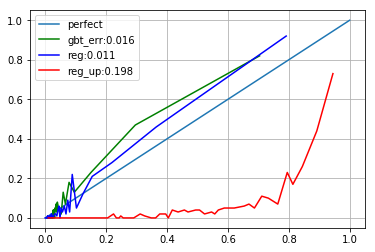

In [3]:
returnRate_gbt, scores_gbt, err_gbt = calibrationError(predictions, "predGbt")
returnRate_reg, scores_reg, err_reg = calibrationError(predictions, "predReg")
returnRate_regup, scores_regup, err_regup = calibrationError(predictions, "predReg_up")
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot([0, 1], [0, 1], label = "perfect")
plt.plot(scores_gbt, returnRate_gbt, color = 'g', label = "gbt_err:{:.3f}".format(err_gbt))
plt.plot(scores_reg, returnRate_reg, color = 'b', label = "reg:{:.3f}".format(err_reg))
plt.plot(scores_regup, returnRate_regup, color = 'r', label = "reg_up:{:.3f}".format(err_regup))
plt.legend()
plt.grid()
plt.show()

In [4]:
print("Calibration error gbt: {:.3f}".format(err_gbt))
print("Calibration error logreg: {:.3f}".format(err_reg))
print("Calibration error upsampled-logreg: {:.3f}".format(err_regup))

Calibration error gbt: 0.016
Calibration error logreg: 0.011
Calibration error upsampled-logreg: 0.198


### Calibration algorithm

In [5]:
def trainCalibration(predictions, modelName, bucketSize = 100):
    count, sumLabel = 0, 0
    buckets = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        count = count + 1
        if(count == bucketSize):
            returnRate = sumLabel / float(bucketSize)
            buckets.append((row[modelName], returnRate))
            count, sumLabel = 0, 0
    
    buckets.append((1,1))
    return buckets

In [6]:
def getCalibratedProb(p, calibBuckets):
    i = 0
    final_p = 0
    while(p > calibBuckets[i][0]):
        final_p = calibBuckets[i][1]
        i = i+1
    return final_p

In [7]:
 predictions_train = pd.read_csv("./data/predictions_train_up.csv")

In [28]:
calibGbt = trainCalibration(predictions_train, "predGbt")
predictions["calibGbt"] = predictions["predGbt"].apply(lambda x: getCalibratedProb(x, calibGbt))
err_gbt_calib = calibrationError(predictions, "calibGbt")[2]
print("Calibration error gbt: \t \t \t {:.3f}".format(err_gbt))
print("Calibration error calibrated GBT: \t {:.3f}".format(err_gbt_calib))

Calibration error gbt: 	 	 	 0.016
Calibration error calibrated GBT: 	 0.013


In [22]:
calibReg = trainCalibration(predictions_train, "predReg")
predictions["calibReg"] = predictions["predReg"].map(lambda x: getCalibratedProb(x, calibReg))
err_reg_calib = calibrationError(predictions, "calibReg")[2]
print("Calibration error logreg: \t \t {:.3f}".format(err_reg))
print("Calibration error calibrated LogReg: \t {:.3f}".format(err_reg_calib))

Calibration error logreg: 	 	 0.011
Calibration error calibrated LogReg: 	 0.009


In [21]:
calibReg_up = trainCalibration(predictions_train, "predReg_up")
predictions["calibReg_up"] = predictions["predReg_up"].map(lambda x: getCalibratedProb(x, calibReg_up))
err_regup_calib = calibrationError(predictions, "calibReg_up")[2]
print("Calibration error upsampled-logreg: \t \t {:.3f}".format(err_regup))
print("Calibration error calibrated upsampled LogReg: \t {:.3f}".format(err_regup_calib))

Calibration error upsampled-logreg: 	 	 0.198
Calibration error calibrated upsampled LogReg: 	 0.019


In [11]:
# df1 = predictions.sort_values(['predReg']).reset_index(drop=True)
# df2 = df1.groupby(np.arange(len(df1))//100).mean()